# **Quest 2: Shark attacks.**
# This analysis of shark attack data aims to provide insights into key activities, species, and countries.


**Main Objective:** To obtain information regarding these three critical columns for the purpose of creating a new business focused on offering scuba diving experiences, primarily centered around encounters with marine wildlife, especially sharks.

In [512]:
#Installing fuzzywuzzy, python-Levenshtein and seaborn
!pip install fuzzywuzzy
#!pip install python-Levenshtein
#!pip install seaborn

import pandas as pd
import numpy as np
import re  # Import the library for working with regular expressions
from fuzzywuzzy import process
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# **Reading raw file**

In [513]:
#Read file
df_shark = pd.read_excel("https://www.sharkattackfile.net/spreadsheets/GSAF5.xls")
df_shark.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-09-16 00:00:00,2024.0,Unprovoked,Morocco,Southern Morocco,West of Dakhla,Swimming - jumped off yacht,German Tourist,F,30,...,Reportedly a Great White,Andy Currie: Moroccan World News: Sky News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-08-26 00:00:00,2024.0,Unprovoked,Jamaica,Montego Bay,Falmouth,Spearfishing,Jahmari Reid,M,16,...,Reportedly Tiger Shark,Todd Smith: Daily Mail UK: Sky News: People .com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **First Step: Cleaning Data**

In [514]:
#Delete columns we don't need
columns_delete = ['href', 'Source', 'pdf', 'Case Number', 'Case Number.1', 'original order', 'Unnamed: 21', 'Unnamed: 22', 'href formula', 'Name', 'Sex', 'Age', 'Unnamed: 11']
df_shark = df_shark.drop(columns_delete, axis=1)

In [515]:
# Checking for duplicated values & removing them
duplicates=df_shark.duplicated()  #Identify duplicated values
number_of_duplicates=duplicates.sum()
#Print duplicated values
print(f"Number of duplicated rows:{number_of_duplicates}") #There is not duplicates in this case

# Remove duplicates and update the DataFrame
df_shark=df_shark.drop_duplicates()

#Reset index
df_shark.reset_index(drop=True, inplace=True)

#Checking it works
duplicates_after=df_shark.duplicated()
print(f"Duplicated rows after cleaning:{duplicates_after.sum()}")

Number of duplicated rows:18
Duplicated rows after cleaning:0


In [516]:
#Shape of our Dataframe
df_shark.shape
print("Number of rows:", df_shark.shape[0]) # Number of rows
print("Number of columns:", df_shark.shape[1]) # Number of columns
print()

Number of rows: 6955
Number of columns: 10



In [517]:
#Clean rows in blank
df_shark.dropna(how="all", inplace =True)
#Result no rowws with NA

#Clear column names
df_shark.columns = df_shark.columns.str.strip()

df_shark.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6954 entries, 1 to 6954
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      6954 non-null   object 
 1   Year      6950 non-null   float64
 2   Type      6934 non-null   object 
 3   Country   6902 non-null   object 
 4   State     6472 non-null   object 
 5   Location  6390 non-null   object 
 6   Activity  6369 non-null   object 
 7   Injury    6917 non-null   object 
 8   Time      3439 non-null   object 
 9   Species   3835 non-null   object 
dtypes: float64(1), object(9)
memory usage: 597.6+ KB


In [518]:
#Check unique data (distintc)
df_shark.nunique()

,0
Date,6023
Year,261
Type,12
Country,234
State,914
Location,4534
Activity,1596
Injury,4100
Time,423
Species,1693


In [519]:
#Transform some columns: Country and Year
df_shark['Country'] = df_shark['Country'].str.upper()
df_shark['Country'] = df_shark['Country'].str.replace('?', '')
df_shark['Año'] = df_shark['Date'].str.extract(r'(\d{4})')
df_shark['Merged Year'] = df_shark['Year'].where(df_shark['Year'] != 0, df_shark['Año'])
df_shark['Merged Year'] = df_shark['Merged Year'].astype(float)
df_shark = df_shark.dropna(subset=['Merged Year'])
df_shark['Merged Year'] = df_shark['Merged Year'].astype(int)
df_shark = df_shark[df_shark['Merged Year'] >= 1950]

<ipython-input-519-4afa1ad969ed>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [520]:
#Delete columns we don't need
columns_delete = ['Year', 'Año']
df_shark = df_shark.drop(columns_delete, axis=1)

In [521]:
#Clean column injury

#Cateogries map
categories = {
    'fatal': 'Fatal',
    'human remains': 'Fatal',
    'no injury': 'No injury',
    'non-fatal': 'Injury'
}

def categorize_injury(injury):
    injury = str(injury).lower()  #Convert the value to string directly
    for keyword, category in categories.items():
        if keyword in injury:
            return category
    return 'Injury'

#If there are NaN values, you can fill them in before applying the function
df_shark['Injury'] = df_shark['Injury'].fillna('Unknown').apply(categorize_injury)

print(df_shark['Injury'].unique())

injury_counts = df_shark['Injury'].value_counts()
print(injury_counts)

['Injury' 'Fatal' 'No injury']
Injury
Injury       3767
No injury     728
Fatal         707
Name: count, dtype: int64


In [522]:
df_shark

,Date,Type,Country,State,Location,Activity,Injury,Time,Species,Merged Year
3,2024-09-16 00:00:00,Unprovoked,MOROCCO,Southern Morocco,West of Dakhla,Swimming - jumped off yacht,Injury,1600hr,Reportedly a Great White,2024
4,2024-08-26 00:00:00,Unprovoked,JAMAICA,Montego Bay,Falmouth,Spearfishing,Injury,NaN,Reportedly Tiger Shark,2024
5,2024-08-06 00:00:00,Unprovoked,BELIZE,Gulf of Honduras,Central America,Swimming - Diving,Injury,11.30hr,Reef shark 6ft (1.8m),2024
6,2024-07-23 00:00:00,Unprovoked,AUSTRALIA,NSW,"North Shore Beach, Port Macquarie",Surfing,Injury,1100hr,3m White Shark,2024
7,2024-07-18 00:00:00,Unprovoked,AUSTRALIA,Western Australia,Trigg beach Sterling,Surfing,Injury,1735hr,Undetermined small shall shark,2024
...,...,...,...,...,...,...,...,...,...,...
6907,Before 1957,Provoked,CUBA,Havana Province,Cojimar,"Shark fishing, knocked overboard",Fatal,NaN,NaN,1957
6908,Before 1956,Unprovoked,MARSHALL ISLANDS,Bikini Atoll,NaN,Swimming,Injury,NaN,NaN,1956
6909,Before 1956,Unprovoked,KIRIBATI,Phoenix Islands,Canton Island,Diving,No injury,NaN,NaN,1956
6910,Before Mar-1956,Unprovoked,NORTH PACIFIC OCEAN,NaN,Wake Island,"Fishing, wading with string of fish",Injury,NaN,NaN,1956


In [523]:
#Clean Time column
df_shark['Time'] = df_shark['Time'].astype(str)
df_shark.loc[df_shark['Time'].isin(['?', 'N', 'X', '--', 'Not advised', 'Not stated']), 'Time'] = 'Unknown'
df_shark.replace(r'^\s*$', 'Unknown', regex=True, inplace=True)
df_shark['Time'] = df_shark['Time'].str.replace('"', '', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('.', '', regex=False).str.strip()
df_shark.loc[df_shark['Time'].isna() | (df_shark['Time'] == ''), 'Time'] = 'Unknown'
df_shark['Time'] = df_shark['Time'].str.replace('?', '')
df_shark['Time'] = df_shark['Time'].str.replace('j', '')
df_shark['Time'] = df_shark['Time'].str.lstrip('-')
df_shark['Time'] = df_shark['Time'].str.lstrip('`')
df_shark['Time'] = df_shark['Time'].str.lstrip('<')
df_shark['Time'] = df_shark['Time'].str.lstrip('>')
df_shark.loc[df_shark['Time'].str.endswith('hr', na=False), 'Time'] = df_shark['Time'].str.replace('hr', '', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('hr', '', regex=True).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('h', '', regex=True).str.strip()


df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)early morning.*', value='0600', regex=True)
df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)late morning.*', value='1100', regex=True)
df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)morning.*', value='0900', regex=True)

df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)early afternoon.*', value='1230', regex=True)
df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)late afternoon.*', value='1700', regex=True)
df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)Mid afternoon.*', value='1500', regex=True)
df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)afternoon.*', value='1300', regex=True)
df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)After noon.*', value='1300', regex=True)

df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)night.*', value='2400', regex=True)

df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)Midday.*', value='1200', regex=True)
df_shark['Time'] = df_shark['Time'].replace(to_replace=r'(?i)AM.*', value='0800', regex=True)


df_shark['Time'] = df_shark['Time'].str.replace('Before', '', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('Shortly before 12h00', '12h00', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('Just before 13h00', '13h00', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('Just before 11h00', '11h00', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('Just before sundown', '18h00', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('Shortly before 13h00', '13h00', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('Just before dawn', '6h00', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('2 hrs before sunset', '17h00', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('Just before noon', '12h00', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('Noon', '12h00', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('Shortly after mid24h00', '24h00', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('Just after 12h00', '12h00', regex=False).str.strip()

df_shark['Time'] = df_shark['Time'].str.replace('Possibly same incident as 20000821', 'Unknown', regex=False).str.strip()
df_shark['Time'] = df_shark['Time'].str.replace('2 hours after Opperman', 'Unknown', regex=False).str.strip()

In [524]:
df_shark.head()

,Date,Type,Country,State,Location,Activity,Injury,Time,Species,Merged Year
3,2024-09-16 00:00:00,Unprovoked,MOROCCO,Southern Morocco,West of Dakhla,Swimming - jumped off yacht,Injury,1600,Reportedly a Great White,2024
4,2024-08-26 00:00:00,Unprovoked,JAMAICA,Montego Bay,Falmouth,Spearfishing,Injury,nan,Reportedly Tiger Shark,2024
5,2024-08-06 00:00:00,Unprovoked,BELIZE,Gulf of Honduras,Central America,Swimming - Diving,Injury,1130,Reef shark 6ft (1.8m),2024
6,2024-07-23 00:00:00,Unprovoked,AUSTRALIA,NSW,"North Shore Beach, Port Macquarie",Surfing,Injury,1100,3m White Shark,2024
7,2024-07-18 00:00:00,Unprovoked,AUSTRALIA,Western Australia,Trigg beach Sterling,Surfing,Injury,1735,Undetermined small shall shark,2024


In [525]:
#Normalize Country's name
# Fill NaN with an empty string
df_shark['Country'] = df_shark['Country'].fillna('').astype(str)

# Preprocessing: Convert to uppercase and remove question marks
df_shark['Country'] = df_shark['Country'].str.upper().str.replace('?', '')

# List of valid country names
valid_country_names = sorted([
    'Admiralty Islands', 'Africa', 'Algeria', 'American Samoa', 'Andaman and Nicobar Islands',
    'Angola', 'Antigua', 'Argentina', 'Aruba', 'Asia', 'Atlantic Ocean',
    'Australia', 'Azores', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Bay of Bengal',
    'Belize', 'Bermuda', 'Brazil', 'British Isles', 'British New Guinea', 'British Overseas Territory',
    'British Virgin Islands', 'British West Indies', 'Canada', 'Cape Verde', 'Caribbean Sea',
    'Cayman Islands', 'Central Pacific', 'Ceylon / Sri Lanka','Chile', 'China', 'Coast of Africa', 'Colombia', 'Comoros',
    'Cook Islands', 'Coral Sea', 'Costa Rica', 'Crete', 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
    'Diego Garcia', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England',
    'Equatorial Guinea/Cameroon', 'Falkland Islands', 'Federated States of Micronesia', 'Fiji',
    'France', 'French Polynesia', 'Gabon', 'Georgia', 'Ghana', 'Grand Cayman', 'Greece', 'Greenland',
    'Grenada', 'Guam', 'Guatemala', 'Guinea', 'Gulf of Aden', 'Guyana', 'Haiti', 'Honduras',
    'Hong Kong', 'Iceland', 'India', 'Indian Ocean', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel',
    'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kenya', 'Kiribati', 'Kuwait', 'Lebanon', 'Liberia', 'Libya',
    'Madagascar', 'Malaysia', 'Maldives Islands', 'Malta', 'Marshall Islands', 'Martinique', 'Mauritius',
    'Mayotte', 'Mediterranean Sea', 'Mexico', 'Micronesia', 'Monaco', 'Montenegro', 'Morocco',
    'Mozambique', 'Burma / Myanmar', 'Namibia', 'Netherlands Antilles', 'Nevis', 'New Caledonia',
    'New Guinea', 'New Zealand', 'Nicaragua', 'Nigeria', 'North Atlantic Ocean', 'North Sea',
    'Northern Arabian Sea', 'Northern Mariana Islands', 'Norway', 'Ocean', 'Okinawa', 'Pacific Ocean',
    'Palau', 'Palestinian Territories', 'Panama', 'Papua New Guinea', 'Paraguay', 'Persian Gulf',
    'Peru', 'Philippines', 'Portugal', 'Puerto Rico', 'Red Sea', 'Reunion', 'Russia', 'Samoa',
    'San Domingo', 'Saudi Arabia', 'Scotland', 'Senegal', 'Seychelles', 'Sierra Leone', 'Singapore',
    'Slovenia', 'Solomon Islands/Vanuatu', 'Somalia', 'South Africa',
    'South Atlantic Ocean', 'South Korea', 'South Pacific Ocean', 'Spain', 'St Martin', 'Sudan',
    'Sweden', 'Syria', 'Taiwan', 'Tanzania', 'Tasman Sea', 'Thailand', 'The Balkans',
    'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turks and Caicos', 'Tuvalu',
    'United Arab Emirates', 'United Kingdom', 'United States of America / USA', 'Unknown or Unspecified', 'Uruguay', 'Venezuela',
    'Vietnam', 'West Indies', 'Western Samoa', 'Yemen'
])

#Function to clean and normalize country names
def normalize_country(country):
    country = country.strip()  #Remove any whitespace
    country = country.lower()
    if not country:  #Handle cases where country remains empty
        return 'Unknown or Unspecified'

    #Use fuzzy matching to find the best close name
    best_match = process.extractOne(country, valid_country_names, scorer=process.fuzz.ratio)
    if best_match and best_match[1] > 60:  #If the similarity is sufficiently high
        return best_match[0]
    return country  #If no good match is found, return the original

#Apply normalization to the 'Country' column
df_shark['Country'] = df_shark['Country'].apply(normalize_country)

#Get the list of unique countries after normalization
country_list = df_shark['Country'].unique()
print (f"\nThe list of unique countries is the following:\n\n{list(country_list)}")

#Get the count of each country
country_count=df_shark['Country'].value_counts()
print(f"\nThe value count for each country is: \n\n{country_count}")



The list of unique countries is the following:

['Morocco', 'Jamaica', 'Belize', 'Australia', 'Russia', 'Maldives Islands', 'Turks and Caicos', 'French Polynesia', 'tobago', 'Bahamas', 'India', 'South Africa', 'Mexico', 'New Zealand', 'Egypt', 'Philippines', 'Coral Sea', 'Spain', 'Portugal', 'Samoa', 'Colombia', 'Ecuador', 'New Caledonia', 'Cuba', 'Brazil', 'Seychelles', 'Argentina', 'Fiji', 'England', 'Japan', 'Indonesia', 'Thailand', 'Costa Rica', 'British Overseas Territory', 'Canada', 'Jordan', 'st kitts / nevis', 'St Martin', 'Papua New Guinea', 'Reunion', 'Israel', 'China', 'Ireland', 'Italy', 'Malaysia', 'Libya', 'Unknown or Unspecified', 'Mauritius', 'Solomon Islands/Vanuatu', 'Comoros', 'United Kingdom', 'United Arab Emirates', 'Cape Verde', 'Dominican Republic', 'Cayman Islands', 'Aruba', 'Mozambique', 'Puerto Rico', 'Atlantic Ocean', 'Greece', 'France', 'Trinidad and Tobago', 'Kiribati', 'Diego Garcia', 'Taiwan', 'Palestinian Territories', 'Guam', 'Nigeria', 'tonga', 'Scotl

In [526]:
#Clean activity column
# Fill NaN with "Unknown"
df_shark['Activity'].fillna('Unknown', inplace=True)

#Function to normalize the activity column
def normalize_activity(activity):
    """Converts to lowercase and removes whitespace."""
    return activity.lower().strip()

#Function to map activities using regular expressions
def map_activity(activity):
    """Maps the activity to a normalized form."""
    #Compile regex patterns for efficiency
    activity_mapping = {
        r'\bscuba diving\b': 'Scuba Diving',  #Clear mapping for 'Scuba Diving'
        r'\bfree diving\b': 'Free Diving',  #Correction for specific search
        r'\b(feed|chumming|cage diving|baiting)\b': 'Feeding Sharks',
        r'\bSnorkel\b': 'Snorkeling',
        r'\bfis(hing)?\b': 'Fishing',
        r'\b(Div(ing)?)\b': 'Other Diving',
        r'\b(Swim(ming)?)\b': 'Swimming',
        r'\b(Bath(ing)?)\b': 'Bathing',
        r'\b(Wad(ing)?|Walk(ing)? )\b': 'Walking',
        r'\b(Surf(ing)?)\b': 'Surfing',
        r'\b(Paddle Board)\b': 'Paddle Boarding',
        r'\bFell\b': 'Fell into the water',
        r'\b(Flo|Treading water|Floating)\b': 'Floating',
        r'\b(Kayak|Canoe|Canoing|Paddling|Rowing)\b': 'Kayaking',
        r'\b(Jump(ing)?)\b': 'Jumping',  #Handle both 'Jump' and 'Jumping'
        r'\b(Photo|film)\b': 'Photography',
        r'\b(Air|Sea (disaster))\b': 'Disaster',
        r'\b(kite)\b': 'Kite Surfing',
        r'\b(rescue|life)\b': 'Rescue',
        r'\bStand\b': 'Standing',
        r'\b(Body|Boogie|Boogie Boarding)\b': 'Boogie Boarding',
        r'\bSail\b': 'Sailing',
        r'\bPlay\b': 'Playing',
        r'\bUnknown\b': 'Unknown'
    }


    #Iterate through the activity mapping to find matches
    for pattern, standardized in activity_mapping.items():
        if re.search(pattern, activity, re.IGNORECASE):
            return standardized  #Return the normalized activity if a pattern is found
    return 'Others'  #If no pattern is found, return 'Others'

#Normalize and map the 'Activity' column
df_shark['Activity'] = df_shark['Activity'].apply(normalize_activity).apply(map_activity)

#Get the list of unique activities after normalization
activity_list = df_shark['Activity'].unique()
print(f"\nActivities listed:\n\n{list(activity_list)}")

#Get the count of each activity
activity_count = df_shark['Activity'].value_counts()
print(f"\nThe value count for each Activity is: \n\n{activity_count}")


Activities listed:

['Swimming', 'Others', 'Other Diving', 'Surfing', 'Walking', 'Fell into the water', 'Fishing', 'Unknown', 'Free Diving', 'Scuba Diving', 'Boogie Boarding', 'Floating', 'Kite Surfing', 'Feeding Sharks', 'Standing', 'Kayaking', 'Bathing', 'Photography', 'Disaster', 'Rescue', 'Jumping', 'Snorkeling']

The value count for each Activity is: 

Activity
Surfing                1274
Others                 1239
Swimming                807
Fishing                 565
Unknown                 366
Other Diving            211
Walking                 178
Scuba Diving            138
Boogie Boarding         137
Free Diving              96
Floating                 57
Kayaking                 34
Disaster                 26
Bathing                  22
Fell into the water      14
Standing                 11
Rescue                    7
Kite Surfing              6
Jumping                   6
Feeding Sharks            5
Photography               2
Snorkeling                1
Name: count, d

<ipython-input-526-de8bd154b28d>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [527]:
#Clean Species column
#Fill NaN with "Unknown"
df_shark['Species'].fillna('Unknown species', inplace=True)

#Function to normalize the species column
def normalize_species(species):
    """Converts to lowercase and removes whitespace."""
    return species.lower().strip()

#Function to map species using regular expressions
def map_species(species):
    """Maps the species to a normalized form."""
    #Compile regex patterns for efficiency
    species_mapping = {
        r'\bwhite\b|\bgreat white\b|\bblue pointer\b': 'White Shark',  #Added 'great white'
        r'\btiger\b|\bstriped\b': 'Tiger Shark',  #Added 'striped'
        r'\bwhale\b|\bwhile\b': 'Whale Shark',
        r'\bbull\b|\bzambe\b|\bbu\.\b|\bzambezi\b': 'Bull Shark',  #Added 'zambezi'
        r'\blemon\b': 'Lemon Shark',
        r'\bgalapagos\b': 'Galapagos Shark',
        r'\bdusky\b': 'Dusky Shark',
        r'\bbroadnose\b': 'Broadnose Shark',
        r'\bseven\b|\bcow\b|\bsevengill\b': 'Seven-gill Shark',  #Added 'sevengill'
        r'\bspinner\b': 'Spinner Shark',
        r'\bblue\b': 'Blue Shark',
        r'\bcaribbean\b': 'Caribbean Reef Shark',
        r'\bmako\b': 'Mako Shark',
        r'\breef\b': 'Reef Shark',
        r'\bgrey nurse\b|\bsand tiger\b|\braggedtooth\b|\bragged-tooth\b': 'Ragged-tooth Shark',  #Consistent hyphenation
        r'\bgoblin\b': 'Goblin Shark',
        r'\bbrown\b|\bsandbar\b|\bgrey\b': 'Sandbar Shark',  #Added 'grey'
        r'\bbronze\b|\bcopper\b': 'Bronze Shark',
        r'\bcaptive\b': 'Captive Shark',
        r'\bno shark\b|\bprior to\b|\bnot\b': 'No Shark species',
        r'\bwhitetip\b|\boceanic whitetip\b': 'Whitetip Shark',  #Added 'oceanic whitetip'
        r'\btawny\b|\bbrown nurse\b': 'Tawny Shark',
        r'\bhammerhead\b|\bshovelnose\b|\bsphyrna\b': 'Hammerhead Shark',  #Added 'sphyrna' (genus name)
        r'\bblacktip\b': 'Blacktip Shark',
        r'\bwobbegong\b|\bcarpet\b': 'Wobbegong Shark',
        r'\bnurse\b|\btawny nurse\b': 'Nurse Shark',  #Combined with tawny variation
        r'\bunknown\b': 'Unknown species'
    }

#Iterate through the activity mapping to find matches
    for pattern, standardized in species_mapping.items():
        if re.search(pattern, species, re.IGNORECASE):
            return standardized  #Return the normalized activity if a pattern is found
    return 'Others'  #If no pattern is found, return 'Others'

#Normalize and map the 'Activity' column
df_shark['Species'] = df_shark['Species'].apply(normalize_species).apply(map_species)

#Get the list of unique activities after normalization
species_list = df_shark['Species'].unique()
print(f"\nSpecies listed:\n\n{list(species_list)}")

#Get the count of each activity
species_count = df_shark['Species'].value_counts()
print(f"\nThe value count for each Species is: \n\n{species_count}")

<ipython-input-527-f7f04d3619e5>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.






Species listed:

['White Shark', 'Tiger Shark', 'Reef Shark', 'Others', 'Blacktip Shark', 'No Shark species', 'Bull Shark', 'Sandbar Shark', 'Unknown species', 'Ragged-tooth Shark', 'Seven-gill Shark', 'Lemon Shark', 'Whitetip Shark', 'Bronze Shark', 'Nurse Shark', 'Galapagos Shark', 'Blue Shark', 'Wobbegong Shark', 'Caribbean Reef Shark', 'Mako Shark', 'Whale Shark', 'Spinner Shark', 'Broadnose Shark', 'Tawny Shark', 'Hammerhead Shark', 'Goblin Shark', 'Dusky Shark', 'Captive Shark']

The value count for each Species is: 

Species
Unknown species         1922
Others                  1114
White Shark              654
Tiger Shark              262
No Shark species         256
Bull Shark               212
Blacktip Shark            81
Bronze Shark              77
Ragged-tooth Shark        73
Nurse Shark               67
Reef Shark                66
Wobbegong Shark           62
Spinner Shark             53
Mako Shark                51
Hammerhead Shark          46
Lemon Shark               

In [528]:
df_shark.head(10)

,Date,Type,Country,State,Location,Activity,Injury,Time,Species,Merged Year
3,2024-09-16 00:00:00,Unprovoked,Morocco,Southern Morocco,West of Dakhla,Swimming,Injury,1600,White Shark,2024
4,2024-08-26 00:00:00,Unprovoked,Jamaica,Montego Bay,Falmouth,Others,Injury,nan,Tiger Shark,2024
5,2024-08-06 00:00:00,Unprovoked,Belize,Gulf of Honduras,Central America,Other Diving,Injury,1130,Reef Shark,2024
6,2024-07-23 00:00:00,Unprovoked,Australia,NSW,"North Shore Beach, Port Macquarie",Surfing,Injury,1100,White Shark,2024
7,2024-07-18 00:00:00,Unprovoked,Australia,Western Australia,Trigg beach Sterling,Surfing,Injury,1735,Others,2024
8,2024-07-08 00:00:00,Unprovoked,Russia,Florida,Ponce de Leon Inlet Volusia County,Other Diving,Injury,1115,Blacktip Shark,2024
9,2024-07-05 00:00:00,Unprovoked,Russia,Florida,New Smyrna Beach,Walking,Injury,1615,No Shark species,2024
10,2024-07-04 00:00:00,Unprovoked,Russia,Texas,South Padre Island,Swimming,Injury,Unknown,Bull Shark,2024
11,2024-07-04 00:00:00,Unprovoked,Russia,Texas,South Padre Island,Swimming,Injury,Unknown,Others,2026
12,2024-07-04 00:00:00,Unprovoked,Russia,Texas,South Padre Island,Swimming,Injury,Unknown,Others,2025


In [529]:
df_shark.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5202 entries, 3 to 6911
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         5202 non-null   object
 1   Type         5187 non-null   object
 2   Country      5202 non-null   object
 3   State        4950 non-null   object
 4   Location     4895 non-null   object
 5   Activity     5202 non-null   object
 6   Injury       5202 non-null   object
 7   Time         5202 non-null   object
 8   Species      5202 non-null   object
 9   Merged Year  5202 non-null   int64 
dtypes: int64(1), object(9)
memory usage: 576.1+ KB


# **Second step: EDA analysis**

In [530]:
#Which activity is more dangerous?
activity_counts = df_shark['Activity'].value_counts()
top_10_activities = activity_counts.head(10)
df_top_activities = top_10_activities.reset_index()
df_top_activities.columns = ['Activity', 'Count']
df_top_activities

,Activity,Count
0,Surfing,1274
1,Others,1239
2,Swimming,807
3,Fishing,565
4,Unknown,366
5,Other Diving,211
6,Walking,178
7,Scuba Diving,138
8,Boogie Boarding,137
9,Free Diving,96


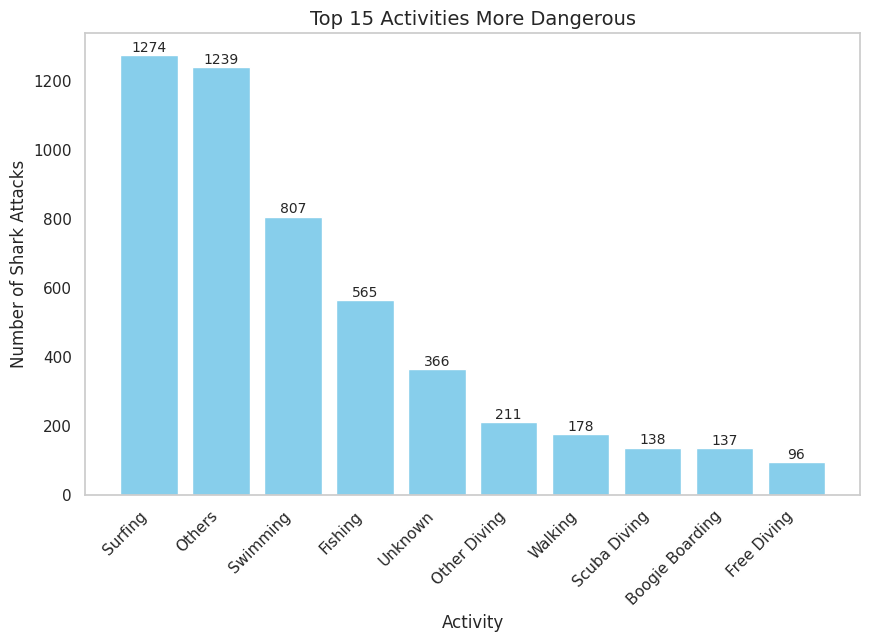

In [531]:

# Data for histogram
activity = df_top_activities['Activity']
counts = df_top_activities['Count']

# Creating histogram
plt.figure(figsize=(10, 6))
plt.bar(activity, counts, color='skyblue')

# Tags
for i in range(len(activity)):
    plt.text(i, counts[i] + 1,
             str(counts[i]),
             ha='center', va='bottom', fontsize=10)

# Plot
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Activities More Dangerous', fontsize=14)
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Number of Shark Attacks', fontsize=12)

# Eliminar las líneas de cuadrícula
plt.grid(False)

In [532]:
#Where are there more attacks?
country_counts = df_shark['Country'].value_counts()
top_15_country = country_counts.head(15)
df_top_countries = top_15_country.reset_index()
df_top_countries.columns = ['Country', 'Count']
df_top_countries

,Country,Count
0,Russia,2197
1,Australia,946
2,South Africa,490
3,Bahamas,124
4,Papua New Guinea,114
5,Brazil,113
6,New Zealand,98
7,Mexico,79
8,Reunion,60
9,New Caledonia,60


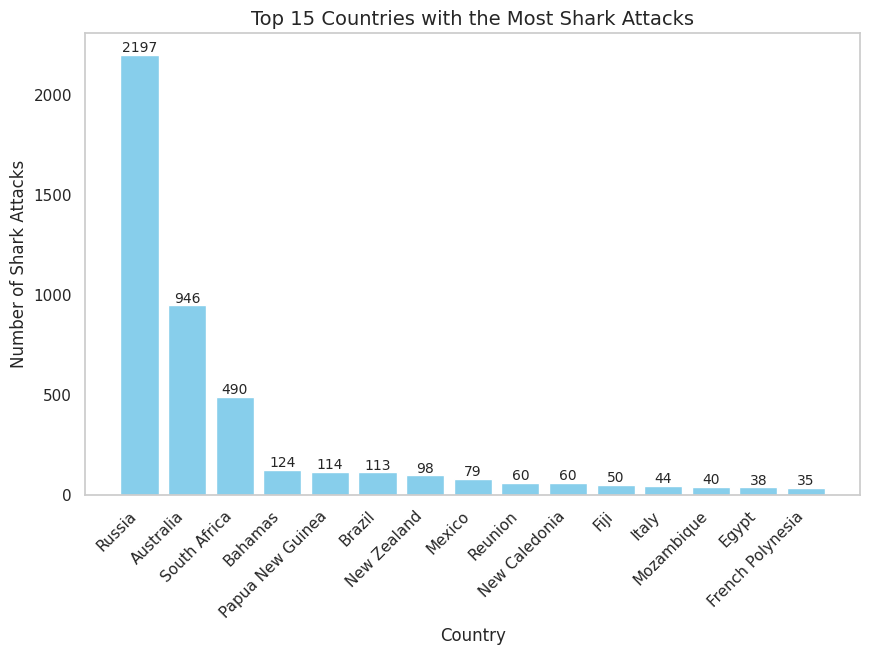

In [533]:
# Data for histogram
countries = df_top_countries['Country']
counts = df_top_countries['Count']

# Creating histogram
plt.figure(figsize=(10,6))
plt.bar(countries, counts, color='skyblue')

#Tags
for i in range(len(countries)):
    plt.text(i, counts[i] + 1,
             str(counts[i]),
             ha='center', va='bottom', fontsize=10)
#Plot
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Countries with the Most Shark Attacks', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Shark Attacks', fontsize=12)

# Eliminar las líneas de cuadrícula
plt.grid(False)

In [534]:
#Plot for shark attacks per country and with each kind of injury

# Step 1: Get the total number of attacks per country
df_total_attacks = df_shark.groupby('Country').size().reset_index(name='Total_Attacks')

# Step 2: Select the top 15 countries with the most shark attacks
df_top_countries = df_total_attacks.nlargest(15, 'Total_Attacks')

# Step 3: Filter the original dataframe to only include the top 15 countries
df_top_shark = df_shark[df_shark['Country'].isin(df_top_countries['Country'])]

# Step 4: Group the filtered data by 'Country' and 'Injury'
df_grouped = df_top_shark.groupby(['Country', 'Injury']).size().reset_index(name='Count')

# Step 5: Get the total counts for each country for sorting
total_counts = df_grouped.groupby('Country')['Count'].sum().reset_index()

# Step 6: Merge to get the total counts back into df_grouped
df_grouped = df_grouped.merge(total_counts, on='Country', suffixes=('', '_Total'))

# Step 7: Sort the grouped data by 'Count_Total' in descending order
df_grouped = df_grouped.sort_values(by='Count_Total', ascending=False)

# Step 8: Create the stacked bar chart for the top 15 countries
fig = px.bar(df_grouped, x='Country', y='Count', color='Injury',
             title="Top 15 Countries with the Most Shark Attacks by Injury Type",
             labels={'Count': 'Number of Shark Attacks', 'Country': 'Country'},
             text='Count')  # Adds the count labels on the bars

# Configure the layout to stack the bars
fig.update_layout(barmode='stack', xaxis_title='Country', yaxis_title='Number of Shark Attacks')

# Show the plot
fig.show()

In [535]:
#Where attacks are deadly?
df_shark_fatal = df_shark[df_shark['Injury'] == 'Fatal']

country_fatal_counts = df_shark_fatal['Country'].value_counts()
top_15_country_fatal = country_fatal_counts.head(15)
df_top_countries_fatal = top_15_country_fatal.reset_index()
df_top_countries_fatal.columns = ['Country', 'Count']
df_top_countries_fatal

,Country,Count
0,Australia,110
1,Russia,90
2,South Africa,73
3,Papua New Guinea,48
4,Mexico,33
5,Brazil,31
6,Reunion,28
7,New Caledonia,20
8,Hong Kong,15
9,Fiji,15


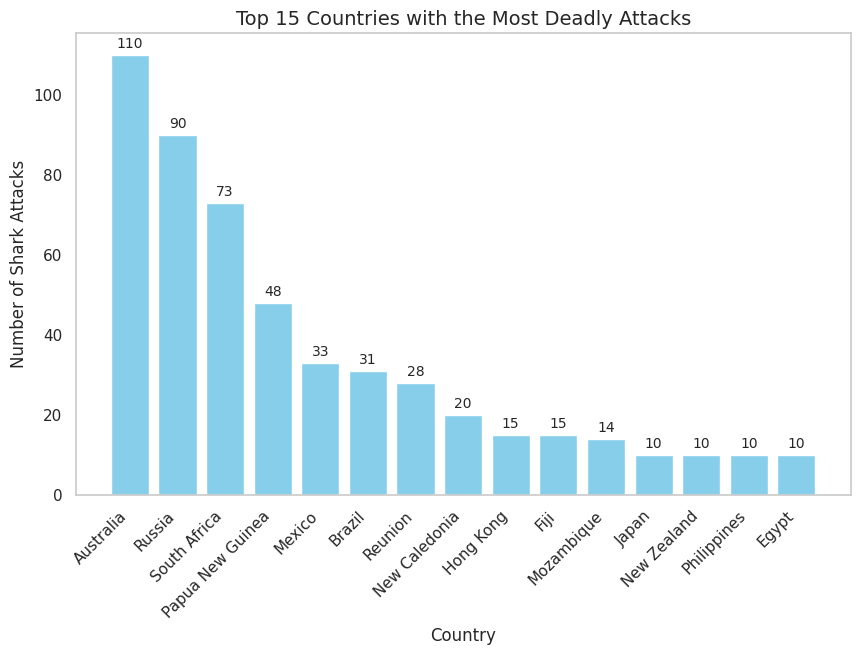

In [536]:
# Data for histogram
countries = df_top_countries_fatal['Country']
counts = df_top_countries_fatal['Count']

# Creating histogram
plt.figure(figsize=(10,6))
plt.bar(countries, counts, color='skyblue')

#Tags
for i in range(len(countries)):
    plt.text(i, counts[i] + 1,
             str(counts[i]),
             ha='center', va='bottom', fontsize=10)
#Plot
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Countries with the Most Deadly Attacks', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Shark Attacks', fontsize=12)

# Eliminate grid
plt.grid(False)

In [537]:
#Percentage of fatal accidents with respect to the total number of accidents

# Merge DataFrames
df_merged = pd.merge(df_top_countries, df_top_countries_fatal, on='Country', suffixes=('_Total', '_Fatal'))

# Check if merge was successful and column names
print(df_merged.columns)

Index(['Country', 'Total_Attacks', 'Count'], dtype='object')


In [538]:
# Rename the columns to more meaningful names
df_merged.rename(columns={'Total_Attacks': 'Count_Total', 'Count': 'Count_Fatal'}, inplace=True)

# Calculate the percentage of fatal accidents with respect to total accidents
df_merged['Fatal_Percentage'] = (df_merged['Count_Fatal'] / df_merged['Count_Total']) * 100

# Sort the DataFrame by Fatal_Percentage in descending order and reset the index
df_merged_sorted = df_merged.sort_values(by='Fatal_Percentage', ascending=False).reset_index(drop=True)

# Display the sorted DataFrame
print(df_merged_sorted)

             Country  Count_Total  Count_Fatal  Fatal_Percentage
0            Reunion           60           28         46.666667
1   Papua New Guinea          114           48         42.105263
2             Mexico           79           33         41.772152
3         Mozambique           40           14         35.000000
4      New Caledonia           60           20         33.333333
5               Fiji           50           15         30.000000
6             Brazil          113           31         27.433628
7              Egypt           38           10         26.315789
8       South Africa          490           73         14.897959
9          Australia          946          110         11.627907
10       New Zealand           98           10         10.204082
11            Russia         2197           90          4.096495


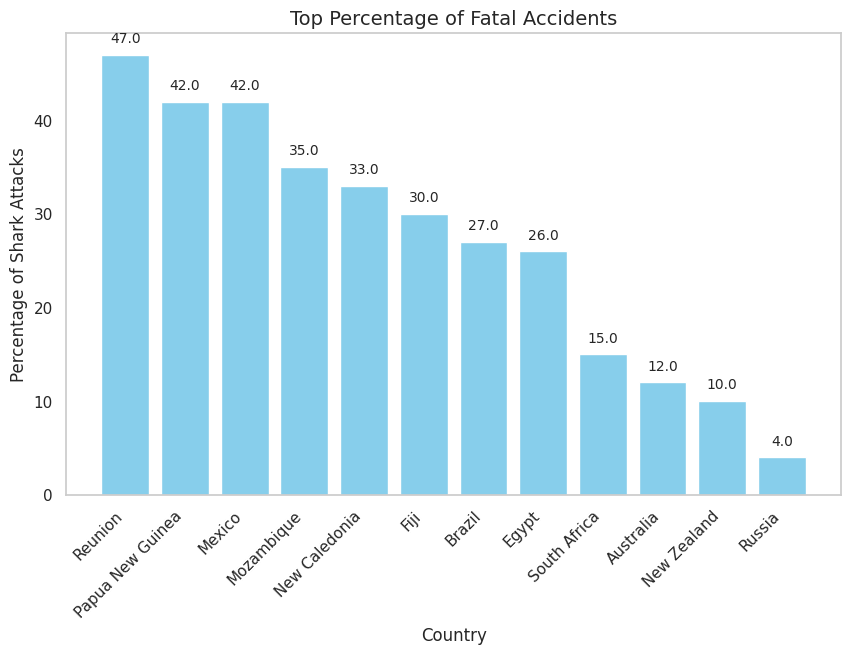

In [539]:
# Data for histogram
countries = df_merged_sorted['Country']
percentage = df_merged_sorted['Fatal_Percentage'].round()

# Creating histogram
plt.figure(figsize=(10,6))
plt.bar(countries, percentage, color='skyblue')

#Tags
for i in range(len(countries)):
    plt.text(i, percentage[i] + 1,
             str(percentage[i]),
             ha='center', va='bottom', fontsize=10)
#Plot
plt.xticks(rotation=45, ha='right')
plt.title('Top Percentage of Fatal Accidents', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Percentage of Shark Attacks', fontsize=12)

# Eliminate grid
plt.grid(False)

In [540]:
#Relating countries to species

#Create and filter the DataFrame
country_species_counts = df_shark.groupby(['Country', 'Species']).size().reset_index(name='Count')
top_countries = df_top_countries['Country']
filtered_country_species_counts = country_species_counts[country_species_counts['Country'].isin(top_countries)]

sorted_filtered_country_species_counts = filtered_country_species_counts.sort_values(by='Count', ascending=False)
sorted_filtered_country_species_counts

,Country,Species,Count
352,Russia,Unknown species,833
346,Russia,Others,543
33,Australia,Unknown species,266
353,Russia,White Shark,217
26,Australia,Others,186
...,...,...,...
158,French Polynesia,Tiger Shark,1
277,New Zealand,Ragged-tooth Shark,1
148,Fiji,White Shark,1
145,Fiji,Reef Shark,1


In [541]:
#Relating countries to species without taking into account the unknown ones.

#Filter to remove rows with species 'Unknown species' or 'Others'.
filtered_sorted_df = sorted_filtered_country_species_counts[
    ~sorted_filtered_country_species_counts['Species'].isin(['Unknown species', 'Others', 'No Shark species'])
]

filtered_sorted_df

,Country,Species,Count
353,Russia,White Shark,217
35,Australia,White Shark,171
392,South Africa,White Shark,160
351,Russia,Tiger Shark,123
336,Russia,Bull Shark,88
...,...,...,...
158,French Polynesia,Tiger Shark,1
277,New Zealand,Ragged-tooth Shark,1
148,Fiji,White Shark,1
145,Fiji,Reef Shark,1


In [542]:
#Number of accidents per species

#Count the number of accidents for each shark species in the original DataFrame
shark_accidents_all_species = df_shark.groupby('Species').size().reset_index(name='Count')
shark_accidents_all_species = shark_accidents_all_species[~shark_accidents_all_species['Species'].isin(['Unknown species', 'Others', 'No Shark species'])]
shark_accidents_all_species_sorted = shark_accidents_all_species.sort_values(by='Count', ascending=False)
shark_accidents_all_species_sorted.reset_index(drop=True)

,Species,Count
0,White Shark,654
1,Tiger Shark,262
2,Bull Shark,212
3,Blacktip Shark,81
4,Bronze Shark,77
5,Ragged-tooth Shark,73
6,Nurse Shark,67
7,Reef Shark,66
8,Wobbegong Shark,62
9,Spinner Shark,53


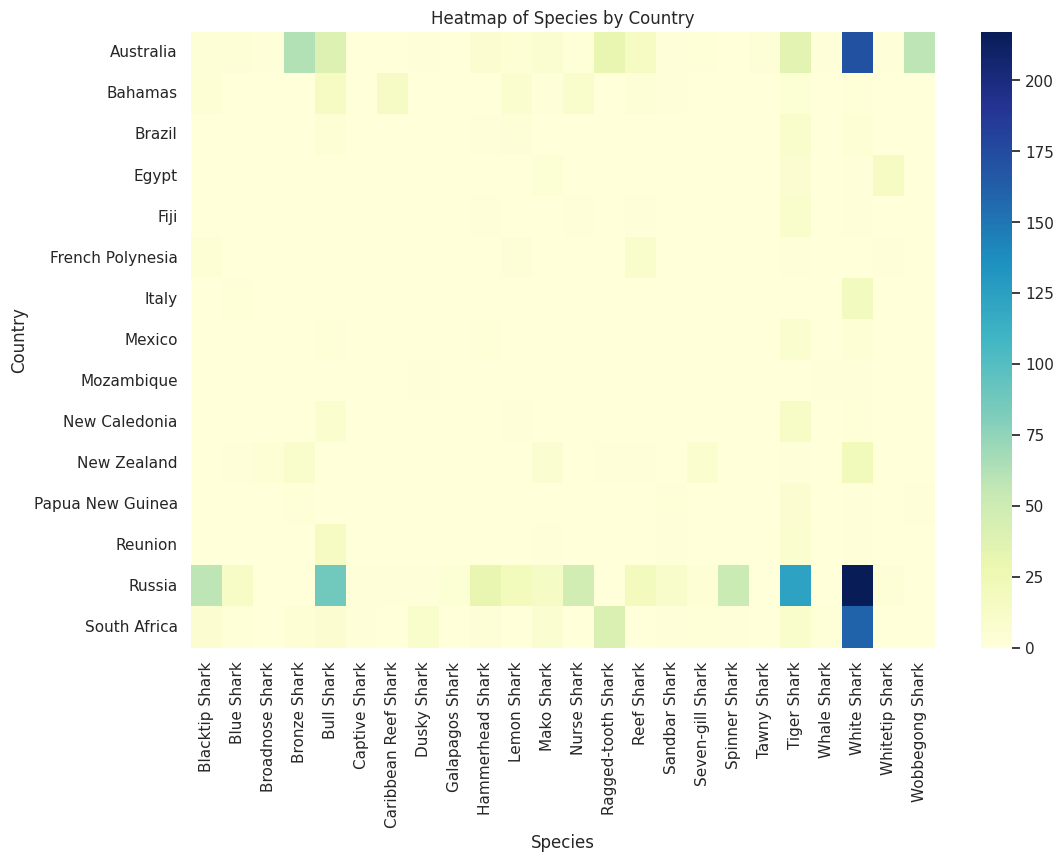

In [543]:
# Create a contingency table
heatmap_data = filtered_sorted_df.pivot_table(index='Country', columns='Species', values='Count', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Heatmap of Species by Country')
plt.xlabel('Species')
plt.ylabel('Country')
plt.show()

In [544]:
# Drop specific values from the DataFrame
filtered_df_shark_species = df_shark[~df_shark['Species'].isin(['Unknown species', 'Others', 'No Shark species'])]

# Count incidents by country and activity
incident_counts = filtered_df_shark_species.groupby(['Country', 'Activity']).size().reset_index(name='Counts')

# Filter for diving activity
diving_incidents = incident_counts[incident_counts['Activity'] == 'Scuba Diving']

# Order the diving incidents by Counts in descending order and reset the index
diving_incidents = diving_incidents.sort_values(by='Counts', ascending=False).reset_index(drop=True)

# Remove the 'Activity' column
diving_incidents = diving_incidents[['Country', 'Counts']]

# Display the ordered diving incidents
diving_incidents


,Country,Counts
0,Australia,21
1,Russia,21
2,South Africa,7
3,Egypt,7
4,Bahamas,4
5,Costa Rica,3
6,New Zealand,3
7,Palau,2
8,Italy,2
9,Fiji,2


In [545]:
# Create a choropleth map with Plotly
fig = px.choropleth(
    diving_incidents,
    locations='Country',  # Column with country names
    locationmode='country names',  # Use country names
    color='Counts',  # Variable to be mapped
    hover_name='Country',  # Show country name on hover
    color_continuous_scale=px.colors.sequential.Plasma,  # Color scale
    title='Scuba Diving Incidents by Country',
    labels={'Counts': 'Number of Incidents'}
)

# Update map layout
fig.update_geos(showcoastlines=True, coastlinecolor="Black")
fig.update_layout(title_font_size=24, title_x=0.5)

# Show the figure
fig.show()

In [546]:
# Step 1: Count incidents by country, activity, and species
incident_counts = df_shark.groupby(['Country', 'Activity', 'Species']).size().reset_index(name='Counts')

# Step 2: Filter for scuba diving incidents and exclude unwanted species
exclude_species = ['Unknown species', 'No Shark species', 'Others']
diving_incidents = incident_counts[(incident_counts['Activity'] == 'Scuba Diving') &
                                   (~incident_counts['Species'].isin(exclude_species))]

# Step 3: Group by species and sum the counts
most_dangerous_species = diving_incidents.groupby('Species')['Counts'].sum().reset_index().sort_values(by='Counts', ascending=False)

# Step 4: Filter countries related to the most dangerous species
dangerous_species_with_countries = diving_incidents[diving_incidents['Species'].isin(most_dangerous_species['Species'])].drop(columns=['Activity'])

# Step 5: Group by country and species, sum the counts, sort, and reset the index
grouped_results_sorted = dangerous_species_with_countries.groupby(['Country', 'Species'])['Counts'].sum().reset_index()
grouped_results_sorted = grouped_results_sorted.sort_values(by=['Country', 'Counts'], ascending=[True, False]).reset_index(drop=True)

# Display the final sorted results
grouped_results_sorted

,Country,Species,Counts
0,Australia,White Shark,11
1,Australia,Ragged-tooth Shark,4
2,Australia,Wobbegong Shark,3
3,Australia,Bull Shark,1
4,Australia,Seven-gill Shark,1
5,Australia,Tiger Shark,1
6,Bahamas,Caribbean Reef Shark,3
7,Bahamas,Lemon Shark,1
8,Brazil,Tiger Shark,1
9,Colombia,Caribbean Reef Shark,1


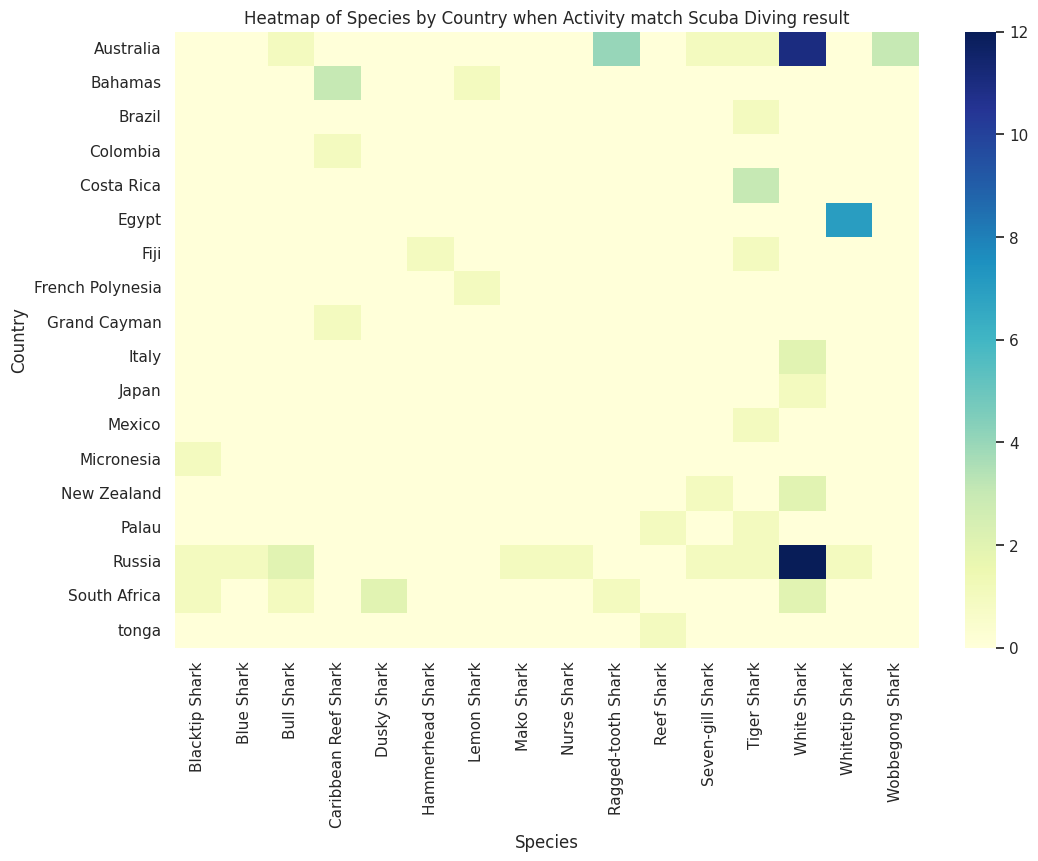

In [547]:
# Create a heatmap table relating Species and Countries inside Scuba Diving category
heatmap_data = grouped_results_sorted.pivot_table(index='Country', columns='Species', values='Counts', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Heatmap of Species by Country when Activity match Scuba Diving result')
plt.xlabel('Species')
plt.ylabel('Country')
plt.show()

In [548]:
# Step 1: Count incidents by country, activity, and species
incident_counts = df_shark.groupby(['Country', 'Activity', 'Species']).size().reset_index(name='Counts')

# Step 2: Filter for scuba diving activity
diving_incidents = incident_counts[incident_counts['Activity'] == 'Scuba Diving']

# Step 3: Find the most dangerous species by counting incidents
# Group by species to get total counts of incidents
species_counts = diving_incidents.groupby('Species')['Counts'].sum().reset_index()

# Sort by counts in descending order to find the most dangerous species
most_dangerous_species = species_counts.sort_values(by='Counts', ascending=False).reset_index(drop=True)

# Display the most dangerous species
most_dangerous_species

,Species,Counts
0,White Shark,30
1,Others,26
2,Unknown species,19
3,No Shark species,13
4,Tiger Shark,9
5,Whitetip Shark,8
6,Ragged-tooth Shark,5
7,Caribbean Reef Shark,5
8,Bull Shark,4
9,Blacktip Shark,3


In [549]:
#Graph of evolution with the years

# Group the data by Country and Merged Year
df_shark_grouped = df_shark.groupby(['Country', 'Merged Year']).size().reset_index(name='Count')

# Ensure the year column is correctly named and formatted
df_shark_grouped.rename(columns={'Merged Year': 'Year'}, inplace=True)

# Create an animated choropleth map
fig = px.choropleth(
    df_shark_grouped,
    locations="Country",
    locationmode='country names',
    color="Count",
    hover_name="Country",
    animation_frame="Year",
    title="Shark Attacks by Country Over the Years",
    color_continuous_scale=px.colors.sequential.Plasma
)

# Show the figure
fig.show()

# **Third Step: Conclusion**

In [550]:
#Check if there are any attacks in Maldives
df_shark_Maldives = df_shark[df_shark["Country"] == "Maldives"]
df_shark_Maldives

,Date,Type,Country,State,Location,Activity,Injury,Time,Species,Merged Year


In [551]:
#Check if there are any attacks in Galapagos
df_shark_Galapagos = df_shark[df_shark["Country"] == "Galapagos"]
df_shark_Galapagos

,Date,Type,Country,State,Location,Activity,Injury,Time,Species,Merged Year


In [552]:
#Check if there are any attacks in Mauritius
df_shark_Mauritius = df_shark[df_shark["Country"] == "Mauritius"]
df_shark_Mauritius

,Date,Type,Country,State,Location,Activity,Injury,Time,Species,Merged Year
708,23-Oct-2017,Unprovoked,Mauritius,Pamplemousses,Le Goulet,Swimming,Injury,1300,Unknown species,2017
1116,20-Nov-2014,Provoked,Mauritius,Cargados Carajos Shoals (St. Brandon),NaN,Fishing,Fatal,nan,Unknown species,2014
2767,22-Apr-1999,Unprovoked,Mauritius,Grand Baie,Pointe aux Canonniers,Swimming,Injury,0600,Reef Shark,1999
2780,29-Jan-1999,Unprovoked,Mauritius,NaN,Belle-Mare,Others,Injury,nan,Bull Shark,1999
3212,06-Jan-1992,Unprovoked,Mauritius,NaN,Mahebourg,Fishing,Injury,nan,Reef Shark,1992
4409,06-Feb-1963,Unprovoked,Mauritius,Rodrigues,NaN,Unknown,Injury,nan,Unknown species,1963
5064,23-Jan-1952,Provoked,Mauritius,Port Louis Province,Port Louis,Others,Injury,nan,Unknown species,1952
